Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

---

In [1]:
# %load_ext watermark
# %watermark -a 'Sebastian Raschka' -v -p torch

# AlexNet CIFAR-10 Classifier

AlexNet [1][2] trained on CIFAR-10 [3].

This implementation uses grouped convolutions like in the original AlexNet paper [2]:

![](../images/alexnet/alexnet-paper.png)

Here, the network is essentially split into two parts to train it on two GPUs with 1.5 Gb RAM each. This was purely done for computational performance reasons (and the video RAM limitation back then). However, there are certain benefits to using grouped convolutions ...


**Taking a step back, how do grouped convolutions work?**

In a nutshell, you can think of grouped convolutions as convolutional layers that process part of the input independently and merge the results. So, for example, if you consider grouped convolutions with two filter groups, each filter group would process half of the channels. 

![](../images/alexnet/grouped-convolutions.png)

**One of the benefits of grouped convolutions is**, as noted by Yani Ioannou [4], that AlexNet has a slightly improved accuracy when using two filter groups:

![](../images/alexnet/alexnet-groups.png)

**Another benefit is the reduced parameter size**. 

Say we have kernels with height 3 and width 3. The inputs have 6 channels, and the output channels are set to 12. Then, we have kernels with 3x3x6 weight parameters with a regular convolution. Since we have 12 output channels, that's 3x3x6x12=648 parameters in total.

Now, let's assume we use a grouped convolution with group size 2. We still have a 3x3 kernel height and width. But now, the number of input channels is split by a factor of 2, so each kernel is 3x3x3. The first group produces the first 6 output channels, so we have 3x3x3x6 parameters for the first group. The second group has the same size, so we have (3x3x3x6)x2 = 3x3x3x12 = 324, which is a 2x reduction in parameters compared to the regular convolution.


**And how do we do this in PyTorch?**

Implementing grouped convolutions in PyTorch is now really straightforward. We just used the `groups` parameter. For example, to implement a grouped convolution with two filter groups we use

    torch.nn.Conv2d(..., groups=2)

Note that a requirement for this is that the number of input and output channels is divisible by groups (here: 2).

### References

- [1] L13.7 CNN Architectures & AlexNet (20:17), https://www.youtube.com/watch?v=-IHxe4-09e4
- [2] Imagenet classification with deep convolutional neural networks, https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
- [3] https://en.wikipedia.org/wiki/CIFAR-10
- [4] https://blog.yani.ai/filter-group-tutorial/

## Imports

In [2]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

#### Setting a random seed

I recommend using a function like the following one prior to using dataset loaders and initializing a model if you want to ensure the data is shuffled in the same manner if you rerun this notebook and the model gets the same initial random weights:

In [3]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

#### Setting cuDNN and PyTorch algorithmic behavior to deterministic

Similar to the `set_all_seeds` function above, I recommend setting the behavior of PyTorch and cuDNN to deterministic (this is particulary relevant when using GPUs). We can also define a function for that:

In [4]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

In [5]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

set_all_seeds(RANDOM_SEED)

# Deterministic behavior not yet supported by AdaptiveAvgPool2d
#set_deterministic()

#### Import utility functions

In [6]:
import sys

sys.path.insert(0, "..") # to include ../helper_evaluate.py etc.

from helper_evaluate import compute_accuracy
from helper_data import get_dataloaders_cifar10
from helper_train import train_classifier_simple_v1

## Dataset

In [7]:
### Set random seed ###
set_all_seeds(RANDOM_SEED)

##########################
### Dataset
##########################

train_transforms = transforms.Compose([transforms.Resize((70, 70)),
                                       transforms.RandomCrop((64, 64)),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((70, 70)),
                                      transforms.CenterCrop((64, 64)),
                                      transforms.ToTensor()])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1)

Files already downloaded and verified


In [8]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([0, 2, 3, 5, 4, 8, 9, 6, 9, 7])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([6, 9, 3, 5, 7, 3, 4, 1, 8, 0])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([2, 6, 3, 1, 1, 1, 1, 2, 4, 8])


## Model

In [9]:
##########################
### MODEL
##########################

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [10]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [11]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS, model=model, 
                                      optimizer=optimizer, device=DEVICE, 
                                      train_loader=train_loader, valid_loader=valid_loader, 
                                      logging_interval=50)

/home/melody/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3021
Epoch: 001/040 | Batch 0050/0175 | Loss: 2.0242


KeyboardInterrupt: 

## Evaluation

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


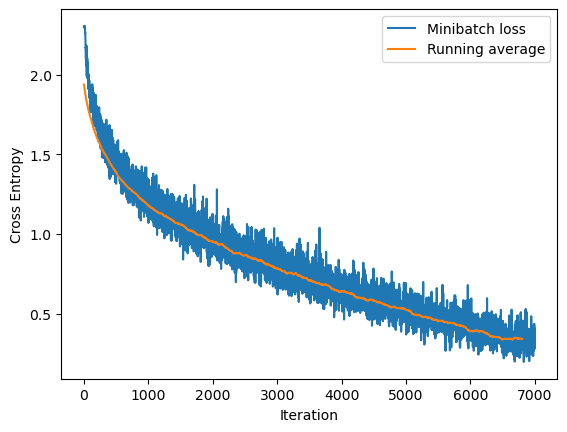

In [ ]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

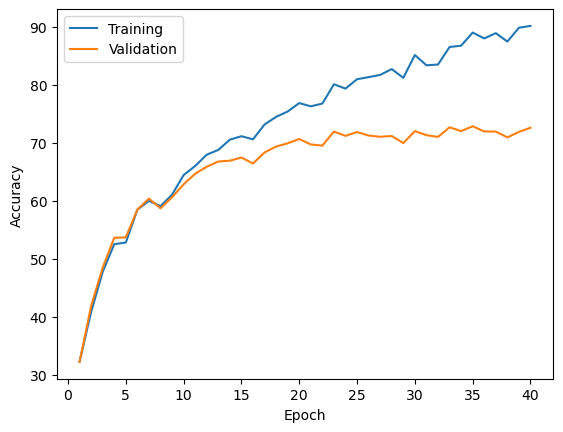

In [ ]:
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 72.62%
Validation ACC: 72.62%
Test ACC: 71.23%


In [ ]:
%watermark -iv

UsageError: Line magic function `%watermark` not found.
